<a href="https://colab.research.google.com/github/rafasacaan/dylan-gpt/blob/main/autoencoders_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. MNIST autoencoder

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Download data and visualize

In [11]:
# Transformer from array to tensors
transform = transforms.ToTensor()

We can extend transformers to :
```{python}
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
```

In [12]:
# Download data
mnist_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform)

# Create dataloader
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_data,
    batch_size=64,
    shuffle=True
)

In [13]:
# Check min/max values of image
data_iter = iter(data_loader)
images, labels = next(data_iter)

display(f'{torch.min(images)=}')
display(f'{torch.max(images)=}')

'torch.min(images)=tensor(0.)'

'torch.max(images)=tensor(1.)'

In [14]:
# Image batch x channels x height x width
images.numpy().shape

(64, 1, 28, 28)

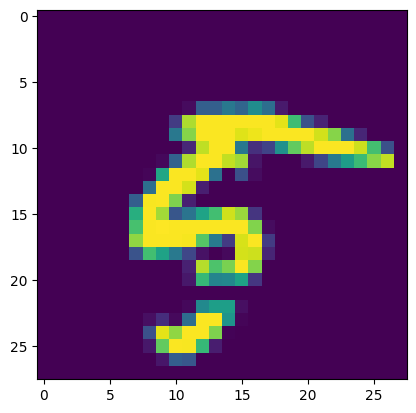

In [15]:
# Plot image
plt.imshow(images[0,0,:,:].numpy())
plt.show();

In [16]:
labels.numpy().shape

(64,)

In [17]:
labels

tensor([5, 5, 8, 0, 7, 3, 0, 2, 2, 0, 5, 5, 6, 4, 3, 0, 8, 6, 4, 6, 3, 3, 8, 4,
        1, 9, 8, 6, 5, 7, 4, 7, 4, 2, 6, 7, 5, 2, 6, 6, 9, 0, 0, 4, 9, 4, 1, 5,
        6, 0, 4, 2, 3, 3, 9, 6, 7, 5, 2, 0, 3, 9, 1, 2])

In [18]:
28*28

784

### Create autoencoder model
The idea is to repeatedly reduce the size

1D autoencoder

In [19]:
class AutoencoderLinear(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # B x 784 -> B x 128
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3), # B x 3
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12),
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

2D autoencoder (CNN)

In [31]:
class AutoencoderCNN(nn.Module):
  def __init__(self):
    super().__init__()

    # N x 1 x 28 x 28
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7), # N, 64, 1, 1
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [32]:
model = AutoencoderCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [33]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
  for (img, _) in data_loader:
    out = model(img)
    loss = criterion(out, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch: {epoch+1}, Loss:{loss.item(): .4f}')
  outputs.append((epoch, img, out))

Epoch: 1, Loss: 0.0077
Epoch: 2, Loss: 0.0054
Epoch: 3, Loss: 0.0040
Epoch: 4, Loss: 0.0033
Epoch: 5, Loss: 0.0035


KeyboardInterrupt: 

IndexError: list index out of range

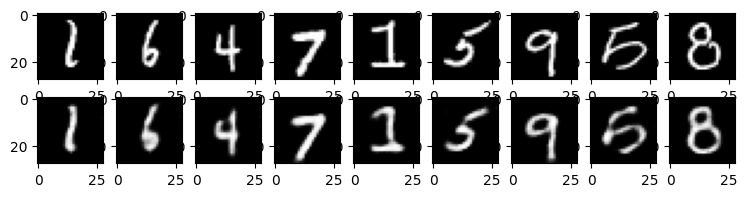

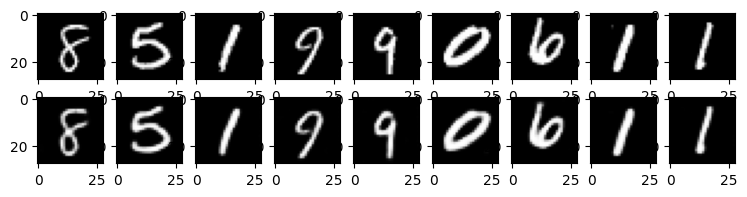

<Figure size 900x200 with 0 Axes>

In [34]:
for k in range(0, num_epochs, 4):

    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])